# ICAPS24 SkDecide Tutorial: Implementing a scikit-decide domain for RDDL problems

Alexandre Arnold, Guillaume Povéda, Florent Teichteil-Königsbuch

Credits to [IMACS](https://imacs.polytechnique.fr/) and especially to Nolwen Huet

In this notebook we demonstrate how to create a custom scikit-decide domain which can then be solved by scikit-decide solvers that are compatible with the custom created domain.

The "characteristic" rosace of scikit-decide domains show that a solver can handle all the domains whose characteristics are *more specific* than the ones of the domain for which the solver has been designed:

<img src="images/skdecide_characteristics.png" alt="SkDecide characteristics" width="1000"/>

For instance, as depicted in this image, if the solver can handle partially observable states, then it can solve also domains whose states are fully observable.

## Environment setup (package installation)

First we install scikit-decide if it has not been already done.

In [ ]:
import os

if not os.path.exists('install_skdecide.py'):
    !wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py

from install_skdecide import install_skdecide
install_skdecide(using_nightly_version=False, force_reinstall=False)

Second, we install RDDL environment, RL bindings and RDDL benchmark set from the excellent [pyrddlgym-project](https://github.com/pyrddlgym-project) GitHub project.

In [ ]:
!pip --default-timeout=1000 install pyRDDLGym pyRDDLGym-rl rddlrepository

Third, we import the packages that will be used in this notebook.

In [33]:
from typing import Any, Dict
from numpy.typing import ArrayLike
import os, shutil
from datetime import datetime as dt
import numpy as np

from stable_baselines3 import PPO as SB3_PPO
from ray.rllib.algorithms.ppo import PPO as RLLIB_PPO

from skdecide.core import TransitionOutcome, Value, Space
from skdecide.domains import RLDomain
from skdecide.builders.domain import UnrestrictedActions, FullyObservable, Renderable
from skdecide.hub.space.gym import GymSpace
from skdecide.hub.solver.ray_rllib import RayRLlib
from skdecide.hub.solver.stable_baselines import StableBaseline
from skdecide.utils import rollout

from gymnasium.spaces.utils import flatten_space, flatten

import pyRDDLGym
from pyRDDLGym_rl.core.env import SimplifiedActionRDDLEnv
from pyRDDLGym.core.visualizer.viz import BaseViz
from pyRDDLGym.core.visualizer.chart import ChartVisualizer
from rddlrepository.core.manager import RDDLRepoManager
from rddlrepository.archive.competitions.IPPC2023.MountainCar.MountainCarViz import MountainCarVisualizer
from pyRDDLGym.core.visualizer.movie import MovieGenerator

import logging

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## Code generation

Scikit-decide's [documentation website](https://airbus.github.io) offers a simple interactive interface to select the characteristics of the domain that you want to define.
It also allows you to generate a template for the domain class to implement, containing the minimal set of methods that you have to implement.

You must go to the [code generator](https://airbus.github.io/scikit-decide/codegen/) page and follow the instructions in the following picture.

<img src="images/skdecide_domain_generator.png" alt="SkDecide domain generator" width="1000"/>

The `pyRDDLGym` package provides a Reinforcement Learning Gym environment whose characteristics correspond to scikit-decide's `RLDomain`, `UnrestrictedActions`, `FullyObservable` and `Renderable` domain characteristics.
`RLDomain` is itself a short-hand meta-characteristic which brings the following additional characteristics: `SingleAgent`, `Sequential`, `Environment`, `Initializable`, `Markovian`, and `Rewards`.

The code generator gives us the following domain class template which we have to fill-in:

```python
from enum import Enum
from typing import *

from skdecide import *
from skdecide.builders.domain import *


# Example of State type (adapt to your needs)
class State(NamedTuple):
    x: int
    y: int


# Example of Action type (adapt to your needs)
class Action(Enum):
    up = 0
    down = 1
    left = 2
    right = 3


class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = State  # Type of states
    T_observation = T_state  # Type of observations
    T_event = Action  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class MyDomain(D):
    
    def _state_step(self, action: D.T_event) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        pass
    
    def _get_action_space_(self) -> Space[D.T_event]:
        pass
    
    def _state_reset(self) -> D.T_state:
        pass
    
    def _get_observation_space_(self) -> Space[D.T_observation]:
        pass

    def _render_from(self, memory: D.T_state, **kwargs: Any) -> Any:
        pass
```

## Domain implementation

The actual work begins now. It consists in implementing the contents of the methods from the generated domain class above.

For our RDDL domain which "just" encapsulates the Gym environment from `pyRDDLGym`, we note:
- the states are dictionaries mapping grounded fluents to their values ;
- the actions are vectors of action values ;
- the logics of generating the initial observation with `RDDLDomain._reset()` and the next observation with `RDDLDomain._step()` is entirely delegated to the underlying RDDL Gym environment ;
- the rendering of the environment with `RDDLDomain._render_from()` also comes from the underluing Gym environment and the resulting image is sent to the notebook's rendering logics ;
- the `RDDLDomain` internally handles the generation of a movie by making use of pyRDDLGym's movie generator ; the movie is generated from intermediate png files in the `Domain._step()` method when the episode reaches a terminal observation or is trunctated

<div class="alert alert-block alert-info"><b>Note: </b> The methods to implement are prefixed with '_' to indicate that they should be considered as protected, i.e. they should not be used by a user of the domain class like a solver. A quick glimpse at the <a href="https://github.com/airbus/scikit-decide/blob/master/skdecide/builders/domain/dynamics.py"> dynamics builder class </a> shows that the class user would actually call the <a href="https://github.com/airbus/scikit-decide/blob/9888102d39624c2acc569994725234f984507f7b/skdecide/builders/domain/dynamics.py#L41"> step() </a> method from which the protected <a href="https://github.com/airbus/scikit-decide/blob/9888102d39624c2acc569994725234f984507f7b/skdecide/builders/domain/dynamics.py#L70"> _step() </a> method is eventually called. The builder classes most generally manage in background the automated casting of domain features to the solver's expected ones (e.g. single agent state to a multi-agent dictionary state if the domain is single-agent and the solver is multi-agent), appropriate re-implementation of methods when walking down the characteristic class hierarchies, and the LRU cache for those methods that can cache their results for later reuse. </div>

<div class="alert alert-block alert-warning"><b>Important: </b> Spaces (e.g. observation space, action space) must be casted to scikit-decide's spaces which are equipped with capabilities required by the various domain builder classes. All Gym spaces have their counterpart scikit-decide spaces, including `gym.Space` which corresponds to `skdecide.hub.space.gym.GymSpace`. </div>

In [4]:
class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = Dict[str, Any]  # Type of states
    T_observation = T_state  # Type of observations
    T_event = ArrayLike  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class RDDLDomain(D):

    def __init__(self,
                 rddl_domain: str,
                 rddl_instance: str,
                 visualizer: BaseViz = ChartVisualizer,
                 movie_name: str = None,
                 max_frames=1000):
        self.rddl_gym_env = pyRDDLGym.make(rddl_domain,
                                           rddl_instance,
                                           base_class=SimplifiedActionRDDLEnv,
                                           enforce_action_constraints=True)
        self.movie_name = movie_name
        self._nb_step = 0
        if movie_name is not None:
            self.movie_path = os.path.join('rddl_movies', movie_name)
            if not os.path.exists(self.movie_path):
                os.makedirs(self.movie_path)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            if os.path.exists(tmp_pngs):
                shutil.rmtree(tmp_pngs)
            os.makedirs(tmp_pngs)
            self.movie_gen = MovieGenerator(tmp_pngs, movie_name, max_frames=max_frames)
            self.rddl_gym_env.set_visualizer(visualizer, self.movie_gen)
        else:
            self.movie_gen = None
            self.rddl_gym_env.set_visualizer(visualizer)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        next_state, reward, terminated, truncated, _ = self.rddl_gym_env.step(action)
        termination = terminated or truncated
        if self.movie_gen is not None and (termination or self._nb_step >= self.movie_gen.max_frames - 1):
            self.movie_gen.save_animation(self.movie_name)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            shutil.move(os.path.join(tmp_pngs, self.movie_name + '.gif'),
                        os.path.join(self.movie_path, self.movie_name + '_' +
                                     str(dt.now().strftime("%Y%m%d-%H%M%S")) +
                                     '.gif'))
        self._nb_step += 1
        # TransitionOutcome and Value are scikit-decide types
        return TransitionOutcome(
            state=next_state, value=Value(reward=reward), termination=termination
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        # Cast to skdecide's GymSpace
        return GymSpace(self.rddl_gym_env.action_space)

    def _state_reset(self) -> D.T_state:
        self._nb_step = 0
        # SkDecide only needs the state, not the info
        return self.rddl_gym_env.reset()[0]

    def _get_observation_space_(self) -> Space[D.T_observation]:
        # Cast to skdecide's GymSpace
        return GymSpace(self.rddl_gym_env.observation_space)

    def _render_from(self, memory: D.T_state = None, **kwargs: Any) -> Any:
        # We do not want the image to be displayed in a pygame window, but rather in this notebook
        rddl_gym_img = self.rddl_gym_env.render(to_display=False)
        clear_output(wait=True)
        display(rddl_gym_img)

## Domain creation

To create our scikit-decide RDDL-bridge domain, we must first search for a RDDL domain and instance.
The pyrddlgym-project provides the [rddlrepository](https://github.com/pyrddlgym-project/rddlrepository) library of RDDL benchmarks from past IPPC competitions and third-party contributors. We list below the available problems with our pip installation of the library.

In [5]:
manager = RDDLRepoManager(rebuild=True)
print(sorted(manager.list_problems()))

['AcademicAdvising_MDP_ippc2014', 'AcademicAdvising_POMDP_ippc2014', 'AcademicAdvising_ippc2018', 'Cartpole_Continuous_gym', 'Cartpole_Discrete_gym', 'ChromaticDice_ippc2018', 'ComplexSysAdmin_rddlsim', 'CooperativeRecon_MDP_ippc2011', 'CooperativeRecon_POMDP_ippc2011', 'CooperativeRecon_ippc2018', 'CrossingTraffic_MDP_ippc2011', 'CrossingTraffic_MDP_ippc2014', 'CrossingTraffic_POMDP_ippc2011', 'CrossingTraffic_POMDP_ippc2014', 'EarthObservation_ippc2018', 'Elevators', 'Elevators_MDP_ippc2011', 'Elevators_MDP_ippc2014', 'Elevators_POMDP_ippc2011', 'Elevators_POMDP_ippc2014', 'GameOfLife_MDP_ippc2011', 'GameOfLife_POMDP_ippc2011', 'HVAC_ippc2023', 'Logistics_rddlsim', 'Manufacturer_ippc2018', 'MarsRover_ippc2023', 'MountainCar_Continuous_gym', 'MountainCar_Discrete_gym', 'MountainCar_ippc2023', 'Navigation_MDP_ippc2011', 'Navigation_POMDP_ippc2011', 'Pendulum_gym', 'Pizza_rddlsim', 'Pong', 'Portfolio', 'PowerGen_Continuous', 'PowerGen_Discrete', 'PowerGen_ippc2023', 'PropDBN_rddlsim', '

Let's create a scikit-decide `RDDLDomain` instance embedding the `MountainCar_ippc2023` benchmark. We render it using scikit-decide.

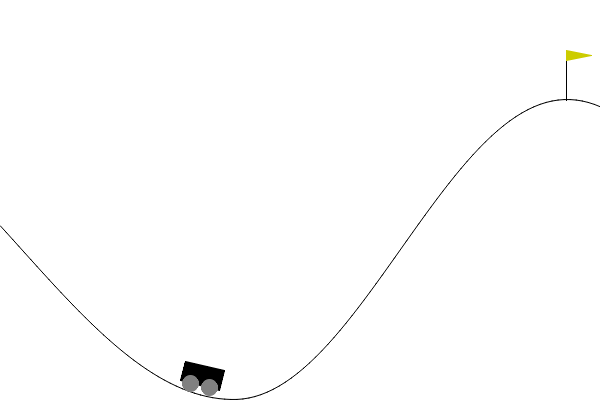

In [19]:
problem_info = manager.get_problem("MountainCar_ippc2023")



domain_factory = lambda alg_name=None: RDDLDomain(rddl_domain=problem_info.get_domain(),
                                                  rddl_instance=problem_info.get_instance(1),
                                                  visualizer=MountainCarVisualizer,
                                                  movie_name='MountainCar_ippc2023-' + alg_name if alg_name is not None else None)
domain = domain_factory()
domain.reset()
domain.render()

## Solving the domain with scikit-decide (potentially bridged) solvers

Now comes the fun part: solving the domain with scikit-decide solvers, some of them - especially the reinforcement learning ones - being bridged to state-of-the-art existing libraries (e.g. RLlib, SB3). You will see that once the domain is defined, solving it takes very few lines of code.

### Solving MountainCar_ippc2023 with RLlib's PPO algorithm

The code below creates a scikit-decide's `RayRLlib` solver, then it calls the `solver.solve()` method, and it finally rollout the optimized policy by using scikit-decide's `rollout` utility function. The latter function will render the solution and the domain will generate a movie in the `rddl_movies` folder when reaching the termination condition of the rollout episode.

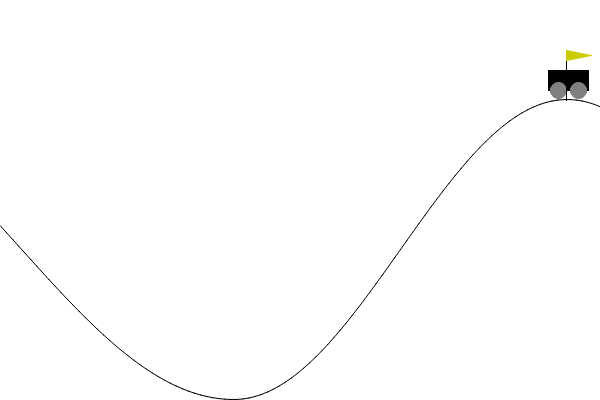

In [24]:
solver_factory = lambda: RayRLlib(
    domain_factory=domain_factory, algo_class=RLLIB_PPO, train_iterations=10
)

with solver_factory() as solver:
    solver.solve()
    rollout(
        domain_factory(alg_name='RLLIB-PPO'),
        solver,
        max_steps=300,
        render=True
    )

Here is an example of executing the RLlib's PPO policy trained for 100 iterations on the mountain car benchmark:

![RLLIB PPO example solution](images/MountainCar_ippc2023-RLLIB-PPO_example.gif)

### Solving MountainCar_ippc2023 with StableBaselines-3's PPO

Once the domain is defined, very few lines of code are sufficient to test another solver whose capabilities are compatible with the domain. In the cell below, we now test Stablebaselines-3's PPO algorithm.

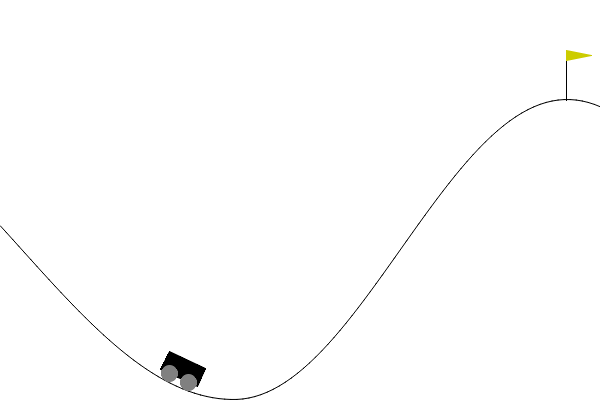

In [36]:
logging.getLogger("skdecide.utils").setLevel(logging.INFO)

solver_factory = lambda: StableBaseline(
    domain_factory=domain_factory,
    algo_class=SB3_PPO,
    baselines_policy="MultiInputPolicy",
    learn_config={"total_timesteps": 10000},
    verbose=0
)

with solver_factory() as solver:
    solver.solve()
    rollout(
        domain_factory(alg_name='SB3-PPO'),
        solver,
        max_steps=1000,
        render=True
    )

### Solving MountainCar_ippc2023 with CGP

Scikit-decide provides an implementation of [Cartesian Genetic Programming](https://dl.acm.org/doi/10.1145/3205455.3205578) (CGP), a form of Genetic Programming which optimizes a function (e.g. control policy) by learning its best representation as a directed acyclic graph of mathematical operators. One of the great capabilities of scikit-decide is to provide simple high-level means to compare algorithms from different communities (RL, GP, search, planning, etc.) on the same domains with few lines of code.

<img src="images/cgp-sketch.png" alt="Cartesian Genetic Programming" width="700"/>

Since our current implementation of CGP in scikit-decide does not handle complex observation spaces such as the dictionary spaces returned by the RDDL simulator, we first specialise our `RDDLDomain` in a `RDDLDomainSimplifiedSpaces` domain where all actions and observations are numpy arrays. To do this, we make use of the powerful `flatten` and `flatten_space` methods of `gymnasium`.

In [8]:
class RDDLDomainSimplifiedSpaces(RDDLDomain):

    def __init__(self,
                 rddl_domain: str,
                 rddl_instance: str,
                 visualizer: BaseViz = ChartVisualizer,
                 movie_name: str = None,
                 max_frames=1000):
        super().__init__(rddl_domain, rddl_instance, visualizer, movie_name, max_frames)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        outcome = super()._state_step(action)
        return TransitionOutcome(
            state=flatten(self.rddl_gym_env.observation_space, outcome.state), value=outcome.value, termination=outcome.termination
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        return GymSpace(flatten_space(self.rddl_gym_env.action_space))

    def _state_reset(self) -> D.T_state:
        # SkDecide only needs the state, not the info
        return flatten(self.rddl_gym_env.observation_space, super()._state_reset())

    def _get_observation_space_(self) -> Space[D.T_observation]:
        return GymSpace(flatten_space(self.rddl_gym_env.observation_space))

Now, we call the CGP solver on this simplified domain and we render the obtained solution after a few iterations (including the generation of the video in the `rddl_movies` folder.

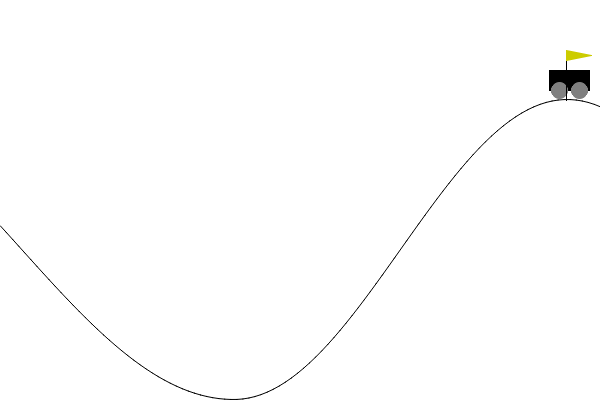

In [22]:
from skdecide.hub.solver.cgp import CGP

domain_factory = lambda alg_name=None: RDDLDomainSimplifiedSpaces(rddl_domain=problem_info.get_domain(),
                                                                  rddl_instance=problem_info.get_instance(1),
                                                                  visualizer=MountainCarVisualizer,
                                                                  movie_name='MountainCar_ippc2023-' + alg_name if alg_name is not None else None,
                                                                  max_frames=200)

domain = domain_factory()

if os.path.exists("TEMP_CGP"):
    shutil.rmtree("TEMP_CGP")
            
# assert CGP.check_domain(domain)
solver_factory = lambda: CGP(
    domain_factory=domain_factory, folder_name="TEMP_CGP", n_it=25, verbose=False
)
with solver_factory() as solver:
    solver.solve()
    rollout(
        domain_factory('CGP'),
        solver,
        max_steps=200,
        render=True
    )

Here is an example of executing the CGP policy on the mountain car benchmark:

![CGP example solution](images/MountainCar_ippc2023-CGP_example.gif)